
**You need to past this to terminal to get access token** 

```
jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' \
  --port=9090 --no-browser
```



In [0]:
import os, sys
os.chdir('/home/koritskiy/rqc/hamiltonian_learning')

import numpy as np
from sklearn.metrics import mean_squared_error as mse
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from modules.matrices import *
from modules.loss_functions import *


In [0]:
# Main function
def construct(N_iterations, d_max_iter, g_max_iter, beta, ising=False):
    param_num = 2 if ising else 5
    TD = []
    MSE = []
    params = []
    
    # initiate coefs (couplings and fields) and angles 
    params_g = np.random.uniform(-1, 1, (param_num, N_spins))
    rho_g = density_matr(params_g, beta, ising)
    angles = np.zeros((2, N_spins))
    
    MSE.append(mse(params_t, params_g))
    TD.append(g_loss_func(params_g, rho_t, angles, beta, ising))
    i = 1
    for _ in range(N_iterations):
      if MSE[-1] < 10 ** -5:
        print("10^-5 MSE threshold was achieved")
        break
        
      # Find most suitable coefs
      result_g = minimize(g_loss_func,
                        args=(rho_t, angles, beta, ising),
                        x0=params_g.reshape(param_num*N_spins),
                        method='Nelder-Mead',
                        options={'maxiter':g_max_iter})
      params_g = np.array(result_g.x).reshape(param_num, N_spins)
      rho_g = density_matr(params_g, beta, ising)
      params.append(params_g)
      # Keep track of errors change
      TD.append(result_g.fun)
      MSE.append(mse(params_t, params_g))
      # Find basis
      result_d = minimize(d_loss_func,
                        args=(rho_g, rho_t),
                        x0=angles.reshape(2*N_spins),
                        method='Nelder-Mead',
                        options={'maxiter':d_max_iter}).x
      angles = result_d.reshape(2, N_spins)
      print(str(i) + "/" + str(N_iterations))
      i += 1
    return MSE, TD, params, angles

In [0]:
# Plot function
def double_plot(MSE, TD):
  X = range(len(MSE))
  fig, ax1 = plt.subplots()


  color = 'tab:red'
  ax1.set_xlabel('iterations')
  ax1.set_ylabel(f'MSE', color=color)
  ax1.scatter(X, MSE, color=color)
  ax1.tick_params(axis='y', labelcolor=color)

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  color = 'tab:blue'
  ax2.set_ylabel(f'TD', color=color)  # we've already handled the x-label with ax1
  ax2.scatter(X, TD, color=color)
  ax2.tick_params(axis='y', labelcolor=color)

  fig.tight_layout()

In [28]:
# Target hamiltonian we need to restore
beta = 0.3
N_spins = 3
ising = False
param_num = 2 if ising else 5

params_t = np.array([[0,0,0],
            [0,0,0],
            [1,1,1],
            [1,1,1],
            [1,1,1]])
# params_t = np.random.uniform(-1, 1, (param_num, N_spins))

rho_t = density_matr(params_t, beta, ising)
rho_t

array([[ 0.01343918+0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  0.10692422+0.j, -0.04121822+0.j,
         0.        +0.j, -0.04121822+0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j],
       [ 0.        +0.j, -0.04121822+0.j,  0.10692422+0.j,
         0.        +0.j, -0.04121822+0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.19482863+0.j,  0.        +0.j, -0.07510449+0.j,
        -0.07510449+0.j,  0.        +0.j],
       [ 0.        +0.j, -0.04121822+0.j, -0.04121822+0.j,
         0.        +0.j,  0.10692422+0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
        -0.07510449+0.j,  0.        +0.j,  0.19482863+0.j,
        -0.07510449+0.j,  0.        +0.j],
       [ 0.        +0.j,  0.      

1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10
CPU times: user 1min 50s, sys: 59.2 ms, total: 1min 50s
Wall time: 1min 50s


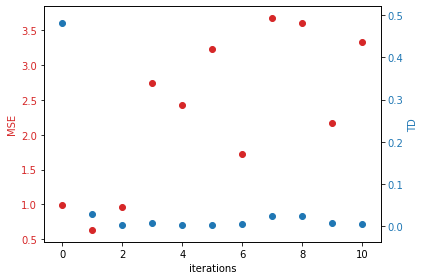

In [29]:
# Run 
%%time
np.random.seed(43)
N_iterations = 10
MSE, TD, params, angles = construct(N_iterations,
                                    d_max_iter=100,
                                    g_max_iter=1100,
                                    beta = 0.3,
                                    ising=ising)
double_plot(MSE, TD)

1/30
2/30
3/30
4/30
5/30
6/30
7/30
8/30
9/30
10/30
11/30
12/30
13/30
14/30
15/30
16/30
17/30
18/30
19/30
20/30
21/30
22/30
23/30
24/30
25/30
26/30
27/30
28/30
29/30
30/30
CPU times: user 35.1 s, sys: 12.3 ms, total: 35.1 s
Wall time: 35 s


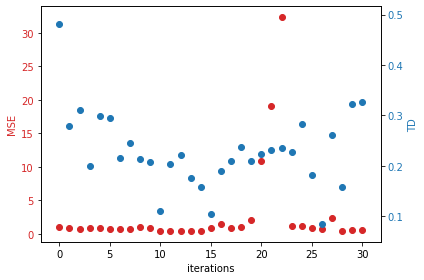

In [33]:
# Run 
%%time
np.random.seed(43)
N_iterations = 30
MSE, TD, params, angles = construct(N_iterations,
                                    d_max_iter=1100,
                                    g_max_iter=100,
                                    beta = 0.3,
                                    ising=ising)
double_plot(MSE, TD)

In [34]:
MSE

[0.9932731582667628,
 0.8469280693392074,
 0.7510040699132879,
 0.8750519004608464,
 0.8375870516929848,
 0.7605881437559611,
 0.7362715952834703,
 0.6360929377639747,
 0.9812552617502122,
 0.8050333483568953,
 0.4141509876919179,
 0.4302756859823437,
 0.4244714253712734,
 0.40533309538673673,
 0.4100020723401096,
 0.8139153047270046,
 1.446754422799991,
 0.851752772433881,
 1.0759641440776397,
 2.0444951203380852,
 10.877991975493904,
 18.9972132381607,
 32.31647935724214,
 1.200496501017845,
 1.0967790800999235,
 0.8964729656124103,
 0.654183584170169,
 2.400049344168463,
 0.444116538325781,
 0.5103843179090598,
 0.492535497445768]

In [12]:
TD

[0.6823259347335084,
 0.3769585454739206,
 0.14928875072805597,
 0.13497313998437424,
 0.133458161745063,
 0.12049849226435833,
 0.11455863858994733,
 0.11190523442721567,
 0.11153828661627406,
 0.11153420751335097,
 0.11152512006590234]

In [16]:
params_t

array([[-0.21009996,  0.60409424, -0.49115775, -0.88623013],
       [ 0.73329728, -0.55794201, -0.1900211 , -0.36780706]])

In [17]:
params[-1]

array([[-0.20842846,  0.60433512, -0.49269013, -0.88587367],
       [ 0.73307843, -0.55795791, -0.19177613, -0.36639927]])

In [0]:
d_max_iters = [i for i in range(100, 2000, 100)]

In [0]:
MSEs = []
TDs = []
paramss = []
for d_iter in d_max_iters:
  np.random.seed(43)
  N_iterations = 20
  MSE, TD, params, angles = construct(N_iterations,
                                    d_max_iter=d_iter,
                                    g_max_iter=2000-d_iter,
                                    beta = 0.3,
                                    ising=ising)
  MSEs.append(MSE)
  TDs.append(TD)
  paramss.appdend(params)
  double_plot(MSE, TD)

1/20
2/20
3/20


/home/koritskiy/rqc/hamiltonian_learning/modules/matrices.py:67: RuntimeWarning: invalid value encountered in true_divide
  rho = sp.linalg.expm(-beta * H) / Z
